# Project: Bank Outages vs Sentiment Analysis 

## Hypothesis 
  Bank customer sentiment is impacted by the number of bank outages experienced, this also affects customer satisfaction (and consequently revenue) 

### Operations
#### Twitter data
Twint to scrape tweets of the top 3 banks in South Africa \
Clean tweets with WordPunctTokenizer and Regex \
TextBlog to process sentiment of tweets 
#### Outage data
https://downdetector.co.za/

#### Customer Satisfaction 
Customer satisfaction index by _____


# Quick Twint code
Github - https://github.com/twintproject/twint

All functions - https://github.com/twintproject/twint/wiki/Configuration
### initialise setup 
c.twint.Config() 
#### set username
c.Username = "realDonaldTrump"
#### set phrase search
c.Search = "great"
#### limitations
c.Limit = 1            ---- limit to batches (unknown size)

c.Since = "2019–04–29"

c.Until = "2020–04–29"
#### Pandas 
c.Pandas = True        -----once run save to dataframe

    ---- Tweets 
    df = twint.storage.panda.Tweets_df
    
    ---- followers 
    df = twint.storage.panda.Follow_df

#### Write output 
c.Store_csv = True

c.Output = "test.csv"

c.Store_json = True

### Execute determines how its run- using setup above
twint.run.Search(c)    --- will run search for all tweets with the above

twint.run.Profile(c)   ---- will run against profile - return only this profiles tweets

twint.run.Followers(c) ---- get follower info 

In [1]:
import twint
import pandas as pd
import nest_asyncio
nest_asyncio.apply()            #for compatibility issues with twint
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import datetime as dt
import seaborn as sns

#cleaning
import re
from nltk.tokenize import WordPunctTokenizer

# NLP
from textblob import TextBlob

#word cloud and stopwords
from wordcloud import WordCloud, STOPWORDS

### Configure and run Twint (twitter scrapper)

In [3]:
def twintConfig(date_from,search_string):    
    c = twint.Config()
    c.Search = search_string
    c.Pandas = True
    c.Since = date_from
    #c.Until = "2021-07-30"
    twint.run.Search(c)
    
#stdBankString = "StandardBankZA OR \"Standard Bank\""
#FNB_String = "FNBSA"

### Run twint

In [4]:
bank_search = {"FNB":"FNBSA", "StandardBank":"StandardBankZA OR \"Standard Bank\""}
since = "2021-08-25"

def Run_Twint(search_vals):
    
    #set empty dataframe
    Final_df= pd.DataFrame()
    
    for bank in search_vals.items():
        print ("running: "+bank[0]+"\n")
        
        #run twint
        twintConfig(since,bank[1])
        
        #get dataframe
        tweets_df = twint.storage.panda.Tweets_df
        
        #join Dataframes and create Bank name column
        tweets_df["Bank"]= bank[0]
        Final_df = pd.concat([Final_df,tweets_df])
    return Final_df

In [6]:
tweets_df = Run_Twint(bank_search)

running: FNBSA

1432972173094817796 2021-09-01 09:42:44 +0200 <ElethuiBongo> @FNBSA Cash@Till®️ is safe and convenient and has helped me to save those withdrawal charges #LoveFNB
1432972098281017344 2021-09-01 09:42:26 +0200 <LoveithaRam> @FNBSA #LoveFNB
1432972008631963651 2021-09-01 09:42:04 +0200 <shibu_siya> @FNBSA Cash till at shoprite helped me because i don't need to town to withdraw money because shoprite is near and no extra charges  #LoveFNB
1432971950079586307 2021-09-01 09:41:50 +0200 <_Tsakani_> @FNBSA #LoveFNB
1432971743317086210 2021-09-01 09:41:01 +0200 <Looploo32418349> @FNBSA Its easy, safe, saves me so much time &amp; very convenient making my life so much easier. #LoveFNB
1432971620935667712 2021-09-01 09:40:32 +0200 <NkosivumileDuma> @FNBSA Helped me a lot , Its free of charge #LoveFNB
1432971532121292802 2021-09-01 09:40:11 +0200 <Gogo86635029> @FNBSA #LoveFNB
1432971522977718274 2021-09-01 09:40:09 +0200 <pennyanneb> @FNBSA With the petrol price as high as it is,

1432966789068120067 2021-09-01 09:21:20 +0200 <getopico> @FNBSA It save time and very convenient I buy groceries and get cash, killing two birds with one stone #LoveFNB
1432966761515790337 2021-09-01 09:21:13 +0200 <wpbefokmanufan> @FNBSA No more spending in long queues at ATMs, it is cheaper to withdraw at the tills than at the ATM... Its nice because I can do shopping and when I pay withdraw money at the till. Talk about "killing" two birds with one stone👌🏾👌🏾👌🏾  #LoveFNB
1432966703328251905 2021-09-01 09:20:59 +0200 <sechuane> @FNBSA Cash at till has helped me a lot when I needed cash urgently, it was very fast, easy and convenient #LoveFNB
1432966701809913860 2021-09-01 09:20:59 +0200 <Elvis39146938> @FNBSA Khanifake noba R200 🕯️🕯️
1432966474910547976 2021-09-01 09:20:05 +0200 <Matome68914605> @FNBSA It has helped me avoid long queues at ATM plus withdrawal charges and I'm able to save #LoveFNB 💙
1432966400876990466 2021-09-01 09:19:47 +0200 <Matome68914605> @FNBSA It has helped me 

1432963716581101570 2021-09-01 09:09:07 +0200 <PButthelezi> @FNBSA #LoveFNB
1432963668933816323 2021-09-01 09:08:56 +0200 <TLethoba> @FNBSA help me understand how I'm getting unauthorized debits and I'm getting charged to correct that????
1432963648209788931 2021-09-01 09:08:51 +0200 <Yvettevanderbe1> @FNBSA #LoveFNB
1432963588629667842 2021-09-01 09:08:37 +0200 <Yvettevanderbe1> @FNBSA #LoveFNB
1432963508459692032 2021-09-01 09:08:18 +0200 <Yvettevanderbe1> @FNBSA #LoveFNB
1432963498158575616 2021-09-01 09:08:15 +0200 <TlhogiVester> @FNBSA It saved me time because it's quick, safer and convenient #LoveFNB
1432963484346720258 2021-09-01 09:08:12 +0200 <Phat_Sii> @FNBSA #LoveFNB Cash@Till has helped me to save on withdrawal fees, save, easy, convenience, avoid long ATM questions and hassle free
1432963465317130243 2021-09-01 09:08:07 +0200 <MazibukoElvis> @FNBSA I'm no longer worrying about go to the ATM to withdraw money, I just go straight to my supermarket till and withdraw money.. e

1432942015440986113 2021-09-01 07:42:53 +0200 <Mwah2u2> @FNBSA #LoveFNB #TheChangeables
1432939137334718471 2021-09-01 07:31:27 +0200 <khozikony> @luale_monze DEFINITELY @McDonalds_SA, @Apple, @Instagram, @YouTube, @PlayStation, @jamesonwhiskey oh and @FNBSA and @Uber definitely need to give me that bag!😂😅
1432935917686243329 2021-09-01 07:18:40 +0200 <Gajeni_> What happened to eBucks @FNBSA @Rbjacobs ?
1432935068876615686 2021-09-01 07:15:17 +0200 <Hector77_THD> @FNBSA its 07:15 but you still locked our money inside. Where must we get our money in the mornings?  https://t.co/ax9K9INogQ
1432935034504335360 2021-09-01 07:15:09 +0200 <monepyamoshe> @FNBSA M  M
1432934571604054019 2021-09-01 07:13:19 +0200 <Amedab> @FNBSA #LoveFNB
1432932102073470981 2021-09-01 07:03:30 +0200 <anneeda_pekeur> @FNBSA A phone call, kind word, a prayer, a food voucher or hamper and some cash is always helpful and needed. Highly appreciated too. #LoveFNB
1432931439163715585 2021-09-01 07:00:52 +0200 <Anzalush

1432810672107180035 2021-08-31 23:00:59 +0200 <Masana94003467> @FNBSA #LoveFNB
1432810621532246020 2021-08-31 23:00:47 +0200 <Masana94003467> @FNBSA #LoveFNB
1432809859146190853 2021-08-31 22:57:45 +0200 <AshikaMaharaj> @FNBSA #LoveFNB Others Before Urself. Like when I decide we cooking n feeding the homeless just out my freezer. Or even exhausted after a long day of work to cook n make care hampers for people with covid who dnt have any1.#TheChangeables  One Act of Random Kindness At A Time
1432809686638731264 2021-08-31 22:57:04 +0200 <MuragaSedina> @FNBSA #LoveFNB
1432807736111243273 2021-08-31 22:49:19 +0200 <AneleBobotyane> @FNBSA Cela imali
1432806966947192835 2021-08-31 22:46:15 +0200 <Zinhle24008571> @FNBSA As for me I do agree with you umuntu ngumuntu ngabantu if we stand together and help each other things would've been better.
1432806173581922314 2021-08-31 22:43:06 +0200 <Zinhle24008571> @FNBSA #loveFNB
1432804105194455041 2021-08-31 22:34:53 +0200 <PertuniaNgoman1> @FNBSA 

1432769335244824579 2021-08-31 20:16:43 +0200 <Kopano61769142> @FNBSA #LoveFNB
1432767861735428099 2021-08-31 20:10:52 +0200 <ramakutana> @FNBSA Blue Valley Golf Estate is a residential estate with more than 1500 houses. Why don't you consider installing a FNB ATM inside Blue Valley Golf Estate 🤷‍♂️.. Maybe it will make business sense?
1432767539172585476 2021-08-31 20:09:35 +0200 <BasetsaneMatro1> @FNBSA #LoveFNB
1432767143452585990 2021-08-31 20:08:01 +0200 <BasetsaneMatro1> @FNBSA #LoveFNB
1432766349793763336 2021-08-31 20:04:51 +0200 <Rendi16362762> @FNBSA are you still partner with @Clicks_SA and @engine?
1432766065143078922 2021-08-31 20:03:44 +0200 <Tshego_13> @FNBSA #LoveFNB
1432765998512365578 2021-08-31 20:03:28 +0200 <Tshego_13> @FNBSA #LoveFNB
1432765947954139137 2021-08-31 20:03:16 +0200 <Tshego_13> @FNBSA #LoveFNB
1432765380007800835 2021-08-31 20:01:00 +0200 <laurengerber1> @FNBSA . #LoveFNB
1432765178026856449 2021-08-31 20:00:12 +0200 <Kgos_Kgos> @FNBSA #LoveFNB
143276

1432739829662486539 2021-08-31 18:19:29 +0200 <Kelebog17873761> @FNBSA #LoveFNB
1432739595683250177 2021-08-31 18:18:33 +0200 <Thabiie_Thabs> @FNBSA @ncuthwa90 Yeeeeeay congratulations 👏
1432739219974279173 2021-08-31 18:17:03 +0200 <BelindaMomberg> @FNBSA #ILoveFNB💖💋
1432737894456778754 2021-08-31 18:11:47 +0200 <Brillia20778497> @FNBSA @ncuthwa90 Congratulations
1432736603374489606 2021-08-31 18:06:39 +0200 <LindokuhleGroot> @FNBSA @ncuthwa90 Congratulations girl
1432735412745740293 2021-08-31 18:01:55 +0200 <DidimDimyati13> @FNBSA I want iphone 😍
1432734305894154249 2021-08-31 17:57:32 +0200 <PeggyTsovisto> @FNBSA Rewards galore 🙌 #LoveFNB
1432731458532265988 2021-08-31 17:46:13 +0200 <ncuthwa90> Thank you so much @LoveFNB @FNBSA
1432731367754944512 2021-08-31 17:45:51 +0200 <ncuthwa90> @FNBSA Thank you to you all fam❤❤❤
1432731154466148353 2021-08-31 17:45:00 +0200 <ConnieMaseko> @BankingZA Why did u give us false info as FNB claims to not have joined this agreement @SnyderDavid78 

1432960726587658242 2021-09-01 08:57:14 +0200 <KeneiloeLevuno> The Standard Bank app is making sure hey.   E mpakela di nerves
1432960651480154114 2021-09-01 08:56:57 +0200 <BokangMatjeke1> @StandardBankZA 🤔🤔
1432960567640199171 2021-09-01 08:56:37 +0200 <HeadMayi> So 3rd day Standard Bank App doesn't work..., 😩
1432960559113195520 2021-09-01 08:56:35 +0200 <selloAP> @StandardBankZA 1st you limit the number of your branches and now we have to deal with this bamking app that doesn't work every month end? Le tlwaela batho masepa lona pila pila 😡
1432960269613948930 2021-09-01 08:55:26 +0200 <AlexanderMay_1> @StandardBankZA Sadly still not working 😟 difficult to explain to people why you can't pay
1432960245995819011 2021-09-01 08:55:20 +0200 <Hulk_ZA> @StandardBankZA app has caused me pain this week logging in. No issues with @FNBSA and @discoverybank
1432960240027328514 2021-09-01 08:55:18 +0200 <Rfq1> @StandardBankZA Why does this happen at month end?
1432960066995564544 2021-09-01 08:

1432940309185449986 2021-09-01 07:36:07 +0200 <Fin24>  https://t.co/tgR9Z5oB3U | Deutsche Bank cuts ties to Standard Bank's Zimbabwean unit  https://t.co/X7eDyC1PFb
1432940261466836994 2021-09-01 07:35:55 +0200 <_kutluuM> @SimplyGoitse_ standard bank
1432933868265476099 2021-09-01 07:10:31 +0200 <MaSengwayo28> Standard bank Zaka 💙💙💙💙🙏
1432932961847070722 2021-09-01 07:06:55 +0200 <Malachi4five6> @StandardBankZA thankyou
1432932233564856323 2021-09-01 07:04:01 +0200 <RealTshemedi> @cruel_im_ii I have MTN and Standard bank sim for that
1432931577558929411 2021-09-01 07:01:25 +0200 <saney_maxwell> I’m enough of Standard Bank app shame. Whenever I need to send account details the girlie freezes
1432930432182591488 2021-09-01 06:56:52 +0200 <Gogo_Dabulamanz> @StandardBankZA @trufm 2 weeks now. My geyser still not assessed. YAZ THE WAY I HATE STANDARD BANK. I WISH IT GETS LIQUIDATED SIES MAAN.
1432928607165460480 2021-09-01 06:49:37 +0200 <Zanele04870431> @947 @StandardBankZA 🙏🙏🙏entered #Ane

1432781207360741379 2021-08-31 21:03:54 +0200 <Bhekala1> SME - Standard Bank - Gauteng  https://t.co/mykVfAH7nr #findwork #resume
1432779327280668674 2021-08-31 20:56:26 +0200 <CuanRS> @Vodacom Please make sure to have one of your legal representatives contact me as soon as possible. Thankfully @StandardBankZA has been able to reverse your fraudulent debit order. Thank you @StandardBankZA
1432778582791753729 2021-08-31 20:53:28 +0200 <TheGreat_Natsby> Not you guys charging R1.10 for email proof of payments you can’t deliver on time @StandardBankZA
1432777422341124106 2021-08-31 20:48:51 +0200 <StandardBankArt> Create a message of support for Fringe artists from NAF on #BankOfDreams and Standard Bank will donate money for every message received. Don’t miss your last chance to make your words count and raise up to R500 000.  https://t.co/mD5fQyfM61 #ItCanBe  https://t.co/LJBXBwSKiT
1432775223963705345 2021-08-31 20:40:07 +0200 <CuanRS> @Vodacom I will be reporting your transactions on my

1432735952871559173 2021-08-31 18:04:04 +0200 <Bhekala1> SME - Standard Bank - Gauteng  https://t.co/SNIuaSinUG #jobs #CV
1432735233154113538 2021-08-31 18:01:13 +0200 <Madikane13> @StandardBankZA I generate these amounts of points every month so this may be an option!
1432734211769786368 2021-08-31 17:57:09 +0200 <Yise_KaMajaji> @StandardBankArt @StandardBankZA But guys my app is still not working kante ikuph inkinga ngempela?
1432733677641928710 2021-08-31 17:55:02 +0200 <Sindy2000p> @StandardBankZA Tell me more 💙 i need an iPhone how much must i be earning inorder to qualify and how does this Ucount points works?
1432732566445072387 2021-08-31 17:50:37 +0200 <SchalkLouw> 2/2  Price/Books on #SouthAfrican #Banks   - Nedbank - Standard Bank  https://t.co/UXUIGyB2LI
1432731515268501504 2021-08-31 17:46:26 +0200 <Kevin_Nevuvha> @StandardBankZA NB  https://t.co/AgPS7lz6Si
1432731309818908673 2021-08-31 17:45:37 +0200 <Tshwaro_24> @StandardBankZA why am i not receiving OTP for online tran

1432693981125779463 2021-08-31 15:17:17 +0200 <Clenton_Selepe> @StandardBankZA Withdrawal
1432692714743767040 2021-08-31 15:12:15 +0200 <thibista_vic> @StandardBankZA lebowakgomo branch 👎i don't know if they short staff or they just don't want to help us,is almost 2hours on a queue to collect a card,2 consultants to help more than 50 ppl,, consultant helps 1 person the leave the desk for 20min,not fair at all i am NOT happy
1432692029767696393 2021-08-31 15:09:32 +0200 <hybridofjudah> @StandardBankZA please check DM
1432691618600128512 2021-08-31 15:07:54 +0200 <Bhekala1> SME - Standard Bank - Gauteng  https://t.co/SNIuaSinUG #findwork #joblinks
1432691181331394567 2021-08-31 15:06:10 +0200 <hybridofjudah> “please hold for a second miss”   20 minutes later .. yo Standard Bank. hayyi
1432690167278710786 2021-08-31 15:02:08 +0200 <ChilledObserver> @StandardBankZA @ZenzoLusengo What are you lying? It's definitely not restored and my virtual card disappeared with my money. Also... Made an 

1432655092197507074 2021-08-31 12:42:46 +0200 <Kani_Ralenkoane> @StandardBankZA Ha le swabi
1432654892720664579 2021-08-31 12:41:58 +0200 <teighdaking> @__AndileN FNB, Standard Bank, ABSA and Bidvest
1432654517892435970 2021-08-31 12:40:29 +0200 <folajoseph> @mr_bukweya @stjohns_college @ss_schools @StandardBankZA @PUMASouthAfrica Nice
1432654134226866176 2021-08-31 12:38:57 +0200 <Mj_TheJoker> @StandardBankZA This is what I am experiencing  https://t.co/CUTVAVazlk
1432654045714554880 2021-08-31 12:38:36 +0200 <Ziyandamgwili> @StandardBankZA Yea, I am tired of paying R10 for immediate transfers.
1432652797175115778 2021-08-31 12:33:38 +0200 <KeletsoMash> @StandardBankZA So frustrating
1432651063035842561 2021-08-31 12:26:45 +0200 <PrettyMpaks> It is becoming a norm that your app doesn't work on month end, been offline the whole morning till now, it's very disappointing @StandardBankZA
1432650800963149828 2021-08-31 12:25:42 +0200 <samosamie> @StandardBankZA Hey Guys! Why aren't there a

1432635458438279168 2021-08-31 11:24:45 +0200 <T_Mthombenii> Le thomile 😒😒 @StandardBankZA
1432635285733625856 2021-08-31 11:24:03 +0200 <DesireePotgiet4> @StandardBankZA It has been almost 2 hours!! When will the app work again? Any news? Any update @StandardBankZA???
1432635244641927169 2021-08-31 11:23:54 +0200 <Reeby_92> Standard Bank sa mbhora shem
1432635017621016579 2021-08-31 11:22:59 +0200 <Betterbust> BEING YOUNG LOOKING IS A BIT WILD WHEN YOU’RE AT THE BANK, THIS LADY’S PROPERLY DOING SOME OTHER PERSONS ACCOUNT IN FRONT OF ME WHILE I’M SITTING  IN FRONT OF HER TRYING TO OPEN MY BUSINESS ACCOUNT 👀 @StandardBankZA
1432634832404766720 2021-08-31 11:22:15 +0200 <news365coza> Standard Bank’s mobile banking app offline  https://t.co/EKwUtXdvOs
1432634795503329281 2021-08-31 11:22:06 +0200 <Malume_Grand> @Jay_Moyana @StandardBankZA 😂😂😂😂😂
1432633719878262789 2021-08-31 11:17:50 +0200 <Jay_Moyana> @StandardBankZA Mnumzane haikhona this happens beke le beke mos, can't we bhubhudla ima

1432614573622939649 2021-08-31 10:01:45 +0200 <__AndileN> @NqobizithaHlu @StandardBankZA A bank!!👌🏽👌🏽👌🏽👌🏽
1432614571332808709 2021-08-31 10:01:45 +0200 <Tetristein> @__AndileN Standard bank and Capitec
1432614145040556033 2021-08-31 10:00:03 +0200 <mankie81080> @ChristoThurston @StandardBankZA I am at wits end with @StandardBankZA. Yoo evet the internet banking they are referring you to is not working 🙄
1432614019643416576 2021-08-31 09:59:33 +0200 <EphraimManamela> @StandardBankZA I never said the app is not working ,I predicted that the app won't work because it's month end ,I used to use std bank&amp;i couldn't take it anymore, i switched my salary to other bank which is more advanced,I was sick&amp;tired of incompetent of std bank,especially month end
1432613786767212548 2021-08-31 09:58:38 +0200 <DesireePotgiet4> @StandardBankZA Do you guys not care about your customers? Is that why it happens every end of the month? #standardbankapp  https://t.co/nvtAvVeBLr
1432613724658061315 20

1432594838747222018 2021-08-31 08:43:20 +0200 <Absa_Mahlangu> @StandardBankZA  https://t.co/ZX6Dya56Cf
1432594812868435968 2021-08-31 08:43:14 +0200 <VillageTraderZA> Standard bank $SBK  https://t.co/Tzu3VEBuYe
1432594812797177858 2021-08-31 08:43:14 +0200 <AzeeMabanga> @TeddyMokone @StandardBankZA I’ve been with them for longer and sometimes that benefits me
1432592835820273667 2021-08-31 08:35:23 +0200 <Absa_Mahlangu> @StandardBankZA cant log on to my internet banking' how long must we wait to transact on the app.
1432592459201122306 2021-08-31 08:33:53 +0200 <Mnix27> @StandardBankZA Thanks again
1432592123090591748 2021-08-31 08:32:33 +0200 <GumbiSduduzo> Am I the only one who is having an issue with their @StandardBankZA App🤨
1432591896682061826 2021-08-31 08:31:39 +0200 <KingMakinati_II> @StandardBankZA @trufm On the last day of the month, your app is down.This screams "Spaghetti code" please hire me so I can help you  https://t.co/fjy7VIwTtd
1432591231855497218 2021-08-31 08:29:0

1432501310776041473 2021-08-31 02:31:41 +0200 <I_Print_Humans> Hi @StandardBankZA, it looks like am not the only having issues here. Someone sent me this on my DM and suggested I speak to the National Credit regulator. Lol  #SphithiphithiEvaluator Uyajola99  https://t.co/ggZHn2OUJW
1432472799898218496 2021-08-31 00:38:24 +0200 <_reba____> @IamBreezy_SA @LawukaziMatt Standard Bank is rather heavy on R20’s.😹
1432472160182980609 2021-08-31 00:35:51 +0200 <hm_rsa> @StandardBankArt @StandardBankZA @sandtontimes  https://t.co/E4ElqF2JzE
1432469287592157186 2021-08-31 00:24:26 +0200 <OupaMota> @LawukaziMatt Standard Bank
1432462645714640900 2021-08-30 23:58:03 +0200 <PeteRobinson985> Standard Bank Holiday Cheshire derby match with @noisyrow and @cooke_chrissie ….. Macclesfield FC the victors vs Congleton……crowd trouble, match delayed … Robbie Savage wading in to sort it all out….  Got to love non league footy 🙄🤣  https://t.co/PXKTsVU9kc
1432461249040633857 2021-08-30 23:52:30 +0200 <DanielTit

1432362382395838475 2021-08-30 17:19:38 +0200 <solitaryman89> Meme woko NDF kwetu oh aano oholongifa bank yiipi standard bank and FNB bank vamona nale bank Windhoek navo kwiinyenga oh ae oh ilo otoshingi etenda loye meembada aano
1432361870527188992 2021-08-30 17:17:36 +0200 <Michell72567612> @StandardBankZA My mommy 💝 she has been through hell this past year this win will be a blessing
1432361685864562690 2021-08-30 17:16:52 +0200 <mailandguardian> While Standard Bank and FNB ward off fintech disruptors, their digital-only competitors battle on the fringes.  https://t.co/vyQIzwAbpk
1432359759865270279 2021-08-30 17:09:13 +0200 <GTAOLOVER> 【GTAO】パシフィック銀行強盗(パシフィナ) 野良メンバーでレクトロ逃走からの渓谷ダイブ Pacific Standard Bank Heist - FINALE 【PS4】  https://t.co/vWmj0lZmhR #GTA5
1432359306872111108 2021-08-30 17:07:25 +0200 <CimplyBM_> @StandardBankZA Because I tweeted its now you want to know whats wrong mxm
1432359246595821572 2021-08-30 17:07:10 +0200 <thegoodwife_> @LawukaziMatt Standard bank
1432358326

1432319901218316289 2021-08-30 14:30:50 +0200 <OmahSadiki> @Betway_za  delay or the standard bank money instant withdrawals system crushed
1432319653905305612 2021-08-30 14:29:51 +0200 <OmahSadiki> @Betway_za  with standard bank money instant delays
1432319428587294720 2021-08-30 14:28:57 +0200 <Tony91115706> What happened to Banks saying for the month of September there wont be any charges when withrawing from any ATM... Is it still there... 🤔🤔Cause i see no difference @StandardBankZA @CapitecBankSA @AbsaSouthAfrica @Nedbank
1432319364368408578 2021-08-30 14:28:42 +0200 <Van_Raath> @StandardBankZA Please advise if we have an IBAN number here in South Africa? I need it for an international payment that I am receiving...
1432312721597468673 2021-08-30 14:02:18 +0200 <MduduziMchunu6> @Sefularo_Keamo @Dusty51266077 Standard bank
1432308918894555138 2021-08-30 13:47:11 +0200 <Bizcat1> Standard Bank Launches Business Banking Awards Worth R4.5 Million in Granting Funds  https://t.co/3wkD05IW

1432252716160536578 2021-08-30 10:03:52 +0200 <Bhekala1> Debt Review Restructure Officer - Standard Bank - Gauteng  https://t.co/QRyMoArxT9 #findwork #jobs
1432251417448812544 2021-08-30 09:58:42 +0200 <maVee_Vincent> @StandardBankZA Hi, what is wrong with your OTP system? I have been waiting over 30 minutes for an OTP to be sent.
1432251057401438212 2021-08-30 09:57:16 +0200 <Anitatao3> @StandardBankZA  how long does it take to open a business account online. Been waiting for a response since last week but dololo response. 😥 Even went to your Fourways branch on Saturday and was given an email address . But hey what a mission
1432250291433484289 2021-08-30 09:54:14 +0200 <noogh23> @StandardBankZA What is the minimum age to add my child as an authorized user on my credit card?
1432250270084440066 2021-08-30 09:54:08 +0200 <Michell72567612> @jozifm Entered done ✅🙌  #ItCanBe  @StandardBankZA
1432249665609773063 2021-08-30 09:51:44 +0200 <MabasoIan> @StandardBankZA @SBGroup maybe you can a

1432233920658030592 2021-08-30 08:49:10 +0200 <CptFreelancer> @LawukaziMatt Standard Bank
1432232868122595331 2021-08-30 08:45:00 +0200 <AlexFMRadio891> It’s Standard Bank Zaka Monday on @Alexfm891. You could win 2.5k cash 💰. And a shop till you drop experience worth 10k at your local mall. Move to #StandardBankZakaMondays and reap the rewards. Enter here:  https://t.co/TrvyFtuOC5 #ItCanBe T&amp;C Apply  https://t.co/J6MX9zkLF5
1432232522071658496 2021-08-30 08:43:37 +0200 <BankservAfrica> Your week in payments: @StandardBankZA's model shifts to platform; New report reveals increased uptake of contactless #payments in SA townships and @juniperresearch shows instant payments will exceed  $28tn in 2026. Read more here:  https://t.co/PnzboFGy3g  https://t.co/LpEFfhenTv
1432229906474283008 2021-08-30 08:33:13 +0200 <Karabo_modikeng> @LawukaziMatt Standard bank
1432228927729197062 2021-08-30 08:29:20 +0200 <J_swegga> @LawukaziMatt @TheRealMotase_ Standard Bank
1432227910958653441 2021-08-30

## Pandas - analyse the data

In [3]:
#Export to csv
#tweets_df.to_csv("pre_cleaning.csv")
tweets_df = pd.read_csv("pre_cleaning.csv")

In [4]:
len(tweets_df)

1224

In [10]:
tweets_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
created_at,1224.0,1.630417e+12,5.341263e+07,1.630302e+12,1.630394e+12,1.630425e+12,1.630471e+12,1.630482e+12
user_id,1224.0,6.017414e+17,6.210915e+17,1.488161e+07,4.545424e+08,4.821307e+09,1.278225e+18,1.432970e+18
day,1224.0,2.114379e+00,6.874574e-01,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,3.000000e+00
video,1224.0,1.143791e-01,3.184012e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
nlikes,1224.0,1.703431e+00,2.429778e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.180000e+02
nreplies,1224.0,5.784314e-01,3.794870e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.110000e+02
nretweets,1224.0,3.316993e-01,3.200742e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.000000e+01


In [7]:
base_tweets = tweets_df[["date", "username", "tweet", "hashtags", "nlikes","search","Bank"]]

In [8]:
base_tweets.head()

,date,username,tweet,hashtags,nlikes,search,Bank
0,2021-08-22 16:47:52,srwaxa,@KS_Nicholson @FNBSA They are thieves and they...,[],0,FNBSA,FNB
1,2021-08-22 16:30:02,Lelo04508066,@FNBSA #LoveFNB,[lovefnb],0,FNBSA,FNB
2,2021-08-22 16:29:57,ThembiMangena1,@FNBSA bank charges are ridiculous 🙄,[],0,FNBSA,FNB
3,2021-08-22 16:24:27,iam_asanele,@FNBSA #LoveFNB I don’t know any woman who st...,[lovefnb],0,FNBSA,FNB
4,2021-08-22 16:16:53,PestroLatifa,@ntshinye @FNBSA @nilotiqa Is that girl who wa...,[],0,FNBSA,FNB


### Cleaning tweet data 


In [9]:
def hash_at_s(text):  
    pat1 = r'@[A-Za-z0-9]+'
    pat2 = r'https?://[A-Za-z0-9./]+'  
    pat3 = r"\'s"                      #floating s's
    combined_pat = r'|'.join((pat1, pat2,pat3))
    text = re.sub(combined_pat,"",text)
    return text

def clean_text(text): 
    text=hash_at_s(text)
    
    text = re.sub('[^A-Za-z\s]', '', text.lower())        #remove non-alphabets, but ignire
    tokenized_text = WordPunctTokenizer().tokenize(text) #tokenize
    clean_text = [
         word for word in tokenized_text
         if word not in STOPWORDS
    ]
    return ' '.join(clean_text)

#### run tween cleaner

In [10]:
cleaned_list = []

for t in base_tweets["tweet"]:
    cleaned_list.append(clean_text(t))

In [11]:
##make a dataframe for sentiment analysis
clean_df = pd.DataFrame(cleaned_list,columns=['tweet'])
clean_df.head()

,tweet
0,nicholson thieves know wont admit yet
1,lovefnb
2,bank charges ridiculous
3,lovefnb dont know woman strives one know crche...
4,girl drunk crying boyfriend left


## Sentiment analysis 

In [12]:
for index, row in clean_df.iterrows():
    tweet = clean_df.at[index, 'tweet']

    #run sentiment using TextBlob
    analysis = TextBlob(tweet)

    #set value to dataframe
    clean_df.at[index, 'polarity'] = analysis.sentiment[0]
    clean_df.at[index, 'subjectivity'] = analysis.sentiment[1]


    #Create Positive / negative column depending on polariity
    if analysis.sentiment[0]>0:

        clean_df.at[index, 'Sentiment'] = "Positive"
        #printmd('Positive', color="green")

    elif analysis.sentiment[0]<0:

        clean_df.at[index, 'Sentiment'] = "Negative"
    else:

        clean_df.at[index, 'Sentiment'] = "Neutral"

In [13]:
clean_df.to_csv("cleaned.csv")
clean_df.head()

,tweet,polarity,subjectivity,Sentiment
0,nicholson thieves know wont admit yet,0.000000,0.000000,Neutral
1,lovefnb,0.000000,0.000000,Neutral
2,bank charges ridiculous,-0.333333,1.000000,Negative
3,lovefnb dont know woman strives one know crche...,-0.100000,0.833333,Negative
4,girl drunk crying boyfriend left,-0.233333,0.533333,Negative


## Merge cleaned and original 

In [80]:
Final_df = clean_df.merge(base_tweets, left_index=True, right_index=True)

In [81]:
Final_df = Final_df.rename(columns={"tweet_x": "cleaned_tweet", "tweet_y": "Base_tweet"})
Final_df.head(5)

,cleaned_tweet,polarity,subjectivity,Sentiment,date,username,Base_tweet,hashtags,nlikes,search,Bank
0,nicholson thieves know wont admit yet,0.000000,0.0,Neutral,2021-08-22 16:47:52,srwaxa,@KS_Nicholson @FNBSA They are thieves and they...,[],0,FNBSA,FNB
0,nicholson thieves know wont admit yet,0.000000,0.0,Neutral,2021-08-22 16:49:02,winner9774,@StandardBankZA 💙Two input ports are missing o...,[becauseucount],0,"StandardBankZA OR ""Standard Bank""",StandardBank
1,lovefnb,0.000000,0.0,Neutral,2021-08-22 16:30:02,Lelo04508066,@FNBSA #LoveFNB,[lovefnb],0,FNBSA,FNB
1,lovefnb,0.000000,0.0,Neutral,2021-08-22 16:49:01,ThusoMakau,@StandardBankZA #GoldenMoments 💛 #ItCanBe htt...,"[goldenmoments, itcanbe]",0,"StandardBankZA OR ""Standard Bank""",StandardBank
2,bank charges ridiculous,-0.333333,1.0,Negative,2021-08-22 16:29:57,ThembiMangena1,@FNBSA bank charges are ridiculous 🙄,[],0,FNBSA,FNB


In [82]:
#ensure date is seen as datetime
Final_df["date"] = pd.to_datetime(Final_df["date"])

#sort by datetime
Final_df = Final_df.sort_values(by="date")

#set index = date so as to create rolling and expanding mean 
Final_df.index = pd.to_datetime(Final_df['date'])

In [83]:
Final_df['mean'] = Final_df['polarity'].expanding().mean()

In [84]:
Final_df['rolling'] = Final_df['polarity'].rolling("1d").mean()

In [85]:
Final_df[["polarity","mean","rolling"]].head(10)

,polarity,mean,rolling
date,,,
2021-08-18 02:06:13,0.171429,0.171429,0.171429
2021-08-18 03:28:50,0.066667,0.119048,0.119048
2021-08-18 05:42:12,0.000000,0.079365,0.079365
2021-08-18 06:04:05,0.000000,0.059524,0.059524
2021-08-18 06:14:30,0.000000,0.047619,0.047619
2021-08-18 06:18:41,0.200000,0.073016,0.073016
2021-08-18 06:22:01,0.000000,0.062585,0.062585
2021-08-18 06:32:04,-0.100000,0.042262,0.042262
2021-08-18 06:33:53,0.000000,0.037566,0.037566


### Check distribution

In [88]:
##### remove neutral values 
Final_df = Final_df[Final_df.polarity != 0]

In [89]:
Final_df[["cleaned_tweet","Bank"]].groupby(["Bank"]).count()

,cleaned_tweet
Bank,
FNB,251
StandardBank,1488


,cleaned_tweet
Sentiment,
Negative,523
Positive,1216


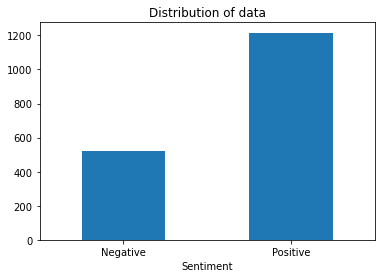

In [90]:
# Plotting the distribution for dataset.
ax = Final_df.groupby('Sentiment').count()["Bank"].plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)
Final_df[["cleaned_tweet","Sentiment"]].groupby(["Sentiment"]).count()

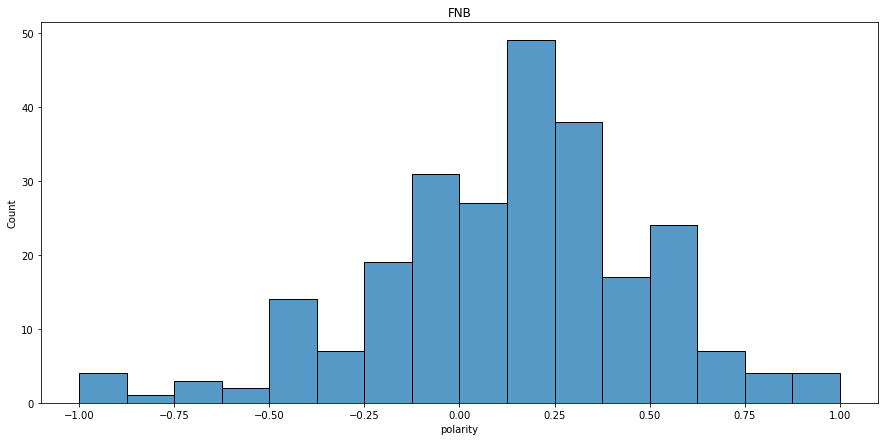

In [91]:
#plot FNB
fig = plt.figure(figsize=(15,7))
FNB_df = Final_df[(Final_df.Bank=="FNB")]
plt.title("FNB")
sns.histplot(FNB_df['polarity'])
plt.show()

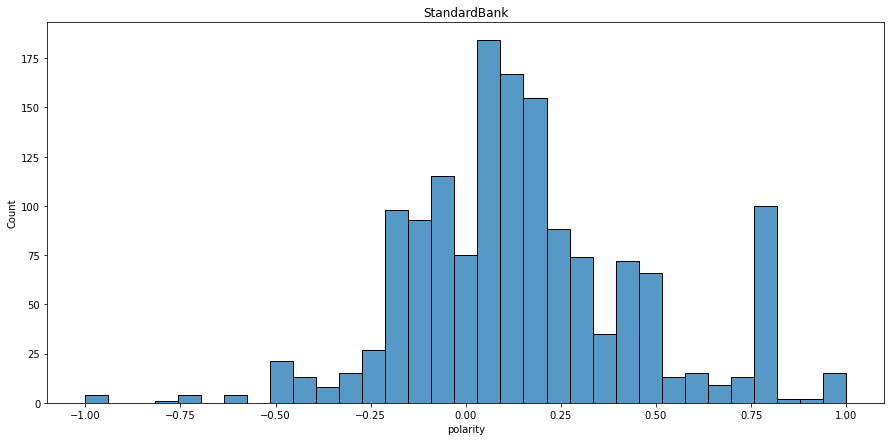

In [92]:
#plot hist
fig = plt.figure(figsize=(15,7))
standard_df = Final_df[(Final_df.Bank=="StandardBank")]
plt.title("StandardBank")
sns.histplot(standard_df['polarity'])
plt.show()

# Word Cloud

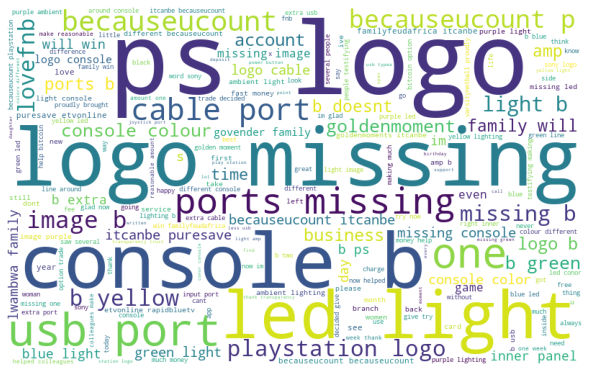

In [26]:
tweetString = " ".join(list(Final_df["cleaned_tweet"])).lower()
tweetString1 = re.sub(r"standardbankza|standard bank|bank","",tweetString)     #remove bank name

wordcloud = WordCloud(width = 800, height = 500, 
                background_color ='white', 
                min_font_size = 5).generate(tweetString1)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0) 
plt.show()

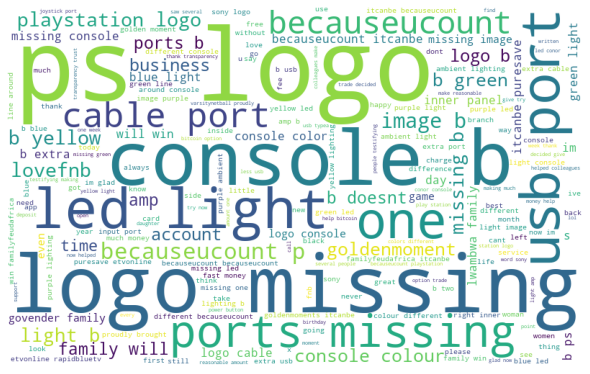

In [27]:
Negative_df = Final_df[(Final_df.Sentiment=="Negative")]
NegativeString = " ".join(list(Negative_df["cleaned_tweet"])).lower()
tweetString1 = re.sub(r"standardbankza|standard bank|bank","",tweetString)     #remove bank name

wordcloud = WordCloud(width = 800, height = 500, 
                background_color ='white', 
                min_font_size = 5).generate(tweetString1)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0) 
plt.show()

# Mean plots

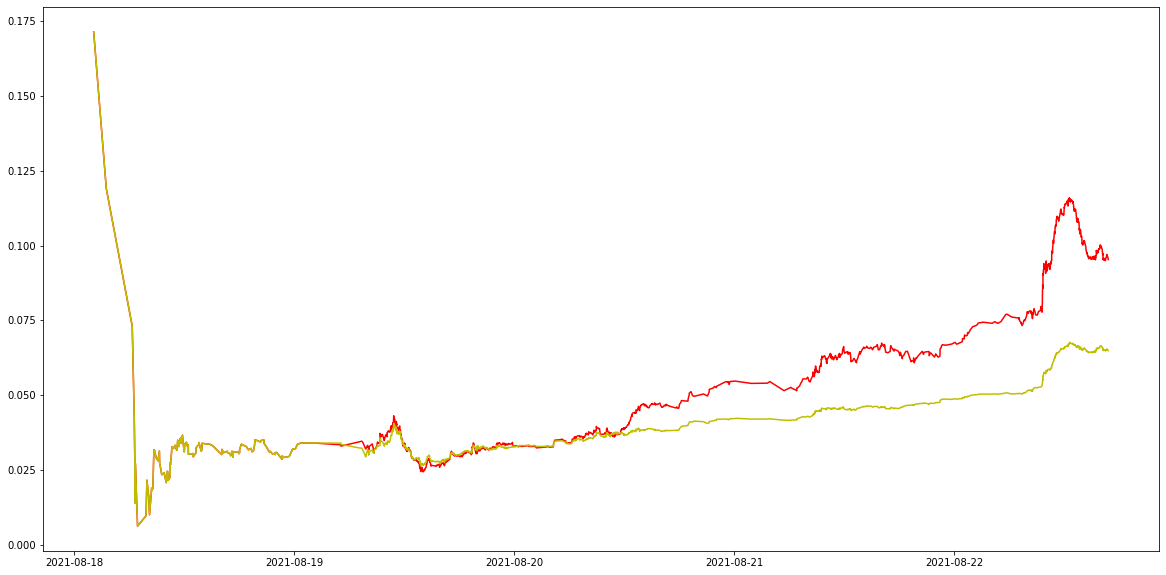

In [69]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

ax.plot(Final_df['date'],Final_df['rolling'], color ='r', label='Rolling Mean')
ax.plot(Final_df['date'],Final_df['mean'], color='y', label='Expanding Mean')
#z= plt.plot(Final_df['date'],Final_df["polarity"])

plt.show()

In [66]:
Final_df.to_csv("NLP_Bank.csv")